<a href="https://colab.research.google.com/github/ernesto-miguez/Machine-Learning-training/blob/master/Churn_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from imblearn.under_sampling import RandomUnderSampler
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier, plot_importance
from sklearn.model_selection import cross_validate
from sklearn.model_selection import GridSearchCV

/usr/local/lib/python3.7/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


In [2]:
# set default matplotlib parameters
COLOR = '#ababab'
mpl.rcParams['figure.titlesize'] = 16
mpl.rcParams['text.color'] = 'black'
mpl.rcParams['axes.labelcolor'] = COLOR
mpl.rcParams['xtick.color'] = COLOR
mpl.rcParams['ytick.color'] = COLOR
mpl.rcParams['grid.color'] = COLOR
mpl.rcParams['grid.alpha'] = 0.1

In [3]:
DATA_PATH = "https://raw.githubusercontent.com/carlosfab/dsnp2/master/datasets/WA_Fn-UseC_-Telco-Customer-Churn.csv"
df = pd.read_csv(DATA_PATH)

In [4]:
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


## DATA ANALYSIS

In [5]:
print("Rows: {}".format(df.shape[0]))
print("Columns: {}".format(df.shape[1]))

Rows: 7043
Columns: 21


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


In [7]:
df.nunique()

customerID          7043
gender                 2
SeniorCitizen          2
Partner                2
Dependents             2
tenure                73
PhoneService           2
MultipleLines          3
InternetService        3
OnlineSecurity         3
OnlineBackup           3
DeviceProtection       3
TechSupport            3
StreamingTV            3
StreamingMovies        3
Contract               3
PaperlessBilling       2
PaymentMethod          4
MonthlyCharges      1585
TotalCharges        6531
Churn                  2
dtype: int64

In [8]:
# Eliminamos customerID ya que es un identificador único y no debe entrar en el modelo
df.drop('customerID', axis=1, inplace=True)

In [9]:
print("Cells filled with whitespace in TotalCharges: {}".format(len(df[df['TotalCharges'] == " "])))

Cells filled with whitespace in TotalCharges: 11


## Replace whitespaces by null values

In [10]:
df.loc[df['TotalCharges'] == ' ', 'TotalCharges'] = np.nan
print("Cells filled with whitespace in TotalCharges: {}".format(len(df[df['TotalCharges'] == " "])))

Cells filled with whitespace in TotalCharges: 0


## Replace null values by the median of "TotalCharges" 

In [11]:
df['TotalCharges'].fillna(df['TotalCharges'].median(), inplace=True)

## Now we can convert TotalCharges column to float

In [12]:
df['TotalCharges'] = df['TotalCharges'].astype(float)

In [13]:
df.describe()

,SeniorCitizen,tenure,MonthlyCharges,TotalCharges
count,7043.000000,7043.000000,7043.000000,7043.000000
mean,0.162147,32.371149,64.761692,2281.916928
std,0.368612,24.559481,30.090047,2265.270398
min,0.000000,0.000000,18.250000,18.800000
25%,0.000000,9.000000,35.500000,402.225000
50%,0.000000,29.000000,70.350000,1397.475000
75%,0.000000,55.000000,89.850000,3786.600000
max,1.000000,72.000000,118.750000,8684.800000


## Draw a boxplot to check for outliers

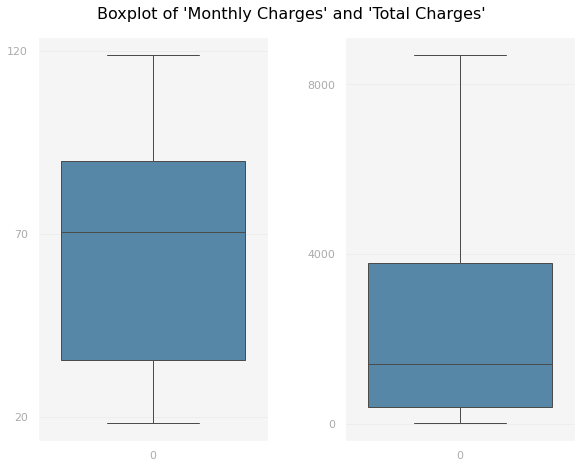

In [14]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(9, 7))
fig.suptitle("Boxplot of 'Monthly Charges' and 'Total Charges'")

boxprops = whiskerprops = capprops = medianprops = dict(linewidth=1)

sns.boxplot(data=df['MonthlyCharges'], orient='v', color='#488ab5', ax=ax[0], 
            boxprops=boxprops, 
            whiskerprops=whiskerprops, 
            capprops=capprops, 
            medianprops=medianprops)
ax[0].set_facecolor('#f5f5f5')
ax[0].set_yticks([20, 70, 120])

sns.boxplot(data=df['TotalCharges'], orient='v', color='#488ab5', ax=ax[1],
            boxprops=boxprops, 
            whiskerprops=whiskerprops, 
            capprops=capprops, 
            medianprops=medianprops)
ax[1].set_facecolor('#f5f5f5')
ax[1].set_yticks([0, 4000, 8000])

plt.tight_layout(pad=4.0);

## Check the value distribution for out target variable Churn

In [15]:
print(df['Churn'].value_counts())
print("\nTotal Churn Rate: {:.2%}".format(df[df['Churn'] == "Yes"].shape[0] / df.shape[0]))

No     5174
Yes    1869
Name: Churn, dtype: int64

Total Churn Rate: 26.54%


## Data preparation

In [16]:
# Extract the unique values for each column
def unique_values():
  for i in np.unique(df.select_dtypes('object').columns):
    print(i, df[i].unique())

unique_values()

Churn ['No' 'Yes']
Contract ['Month-to-month' 'One year' 'Two year']
Dependents ['No' 'Yes']
DeviceProtection ['No' 'Yes' 'No internet service']
InternetService ['DSL' 'Fiber optic' 'No']
MultipleLines ['No phone service' 'No' 'Yes']
OnlineBackup ['Yes' 'No' 'No internet service']
OnlineSecurity ['No' 'Yes' 'No internet service']
PaperlessBilling ['Yes' 'No']
Partner ['Yes' 'No']
PaymentMethod ['Electronic check' 'Mailed check' 'Bank transfer (automatic)'
 'Credit card (automatic)']
PhoneService ['No' 'Yes']
StreamingMovies ['No' 'Yes' 'No internet service']
StreamingTV ['No' 'Yes' 'No internet service']
TechSupport ['No' 'Yes' 'No internet service']
gender ['Female' 'Male']


In [17]:
# Switch 'No internet service' as 'No'
to_binary = ['DeviceProtection', 'OnlineBackup', 'OnlineSecurity', 'StreamingMovies', 'StreamingTV', 'TechSupport']

for i in to_binary:
  df.loc[df[i].isin(['No internet service']), i] = 'No'

In [18]:
unique_values()

Churn ['No' 'Yes']
Contract ['Month-to-month' 'One year' 'Two year']
Dependents ['No' 'Yes']
DeviceProtection ['No' 'Yes']
InternetService ['DSL' 'Fiber optic' 'No']
MultipleLines ['No phone service' 'No' 'Yes']
OnlineBackup ['Yes' 'No']
OnlineSecurity ['No' 'Yes']
PaperlessBilling ['Yes' 'No']
Partner ['Yes' 'No']
PaymentMethod ['Electronic check' 'Mailed check' 'Bank transfer (automatic)'
 'Credit card (automatic)']
PhoneService ['No' 'Yes']
StreamingMovies ['No' 'Yes']
StreamingTV ['No' 'Yes']
TechSupport ['No' 'Yes']
gender ['Female' 'Male']


In [19]:
# Convert 'Churn' values to numerical
df.loc[df['Churn'] == 'No', 'Churn'] = 0
df.loc[df['Churn'] == 'Yes', 'Churn'] = 1
df['Churn'] = df['Churn'].astype(int) 

In [20]:
df.head()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,0
1,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.50,0
2,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,1
3,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,0
4,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,1


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-package

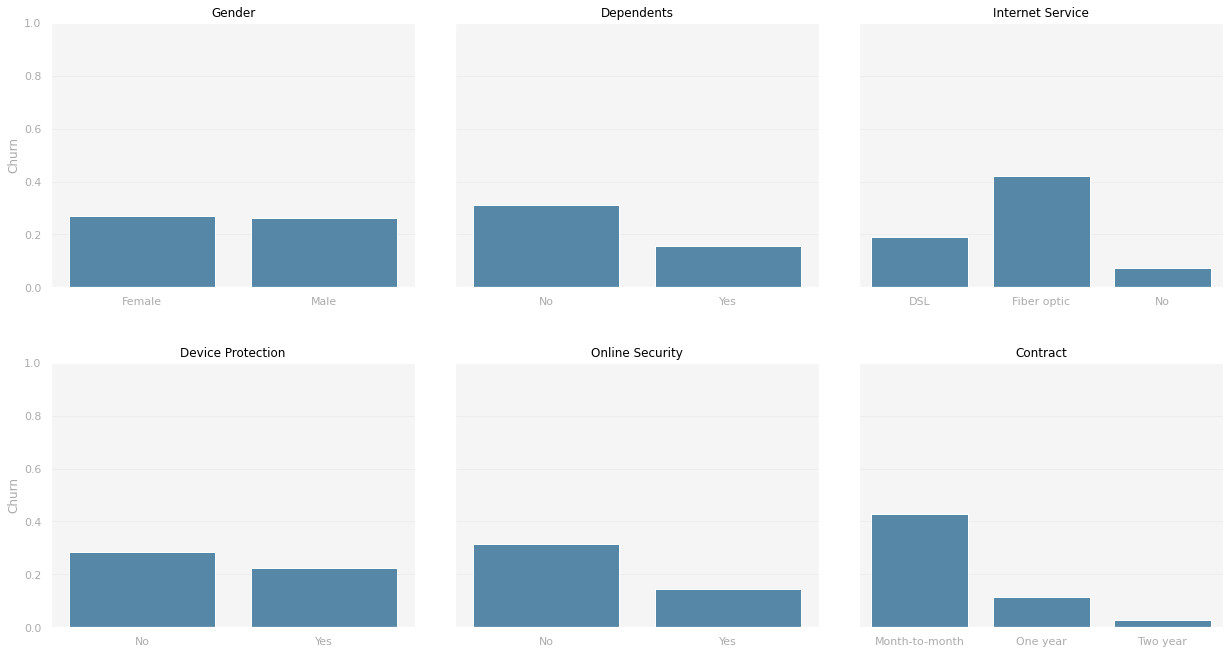

In [21]:
fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(18,10))

sns.barplot(df['gender'], df['Churn'], color='#488ab5', ci=None, ax=ax[0][0])
ax[0][0].set_facecolor('#f5f5f5')
ax[0][0].set_ylim(0,1)
ax[0][0].set_xlabel(None)
ax[0][0].set_title('Gender')

sns.barplot(df['Dependents'], df['Churn'], color='#488ab5', ci=None, ax=ax[0][1])
ax[0][1].set_facecolor('#f5f5f5')
ax[0][1].tick_params(labelleft=False)
ax[0][1].set_ylim(0,1)
ax[0][1].set_ylabel(None)
ax[0][1].set_xlabel(None)
ax[0][1].set_title('Dependents')

sns.barplot(df['InternetService'], df['Churn'], color='#488ab5', ci=None, ax=ax[0][2])
ax[0][2].set_facecolor('#f5f5f5')
ax[0][2].tick_params(labelleft=False)
ax[0][2].set_ylim(0,1)
ax[0][2].set_ylabel(None)
ax[0][2].set_xlabel(None)
ax[0][2].set_title('Internet Service')

sns.barplot(df['DeviceProtection'], df['Churn'], color='#488ab5', ci=None, ax=ax[1][0])
ax[1][0].set_facecolor('#f5f5f5')
ax[1][0].set_ylim(0,1)
ax[1][0].set_xlabel(None)
ax[1][0].set_title('Device Protection')

sns.barplot(df['OnlineSecurity'], df['Churn'], color='#488ab5', ci=None, ax=ax[1][1])
ax[1][1].set_facecolor('#f5f5f5')
ax[1][1].tick_params(labelleft=False)
ax[1][1].set_ylim(0,1)
ax[1][1].set_ylabel(None)
ax[1][1].set_xlabel(None)
ax[1][1].set_title('Online Security')

sns.barplot(df['Contract'], df['Churn'], color='#488ab5', ci=None, ax=ax[1][2])
ax[1][2].set_facecolor('#f5f5f5')
ax[1][2].tick_params(labelleft=False)
ax[1][2].set_ylim(0,1)
ax[1][2].set_ylabel(None)
ax[1][2].set_xlabel(None)
ax[1][2].set_title('Contract')

plt.tight_layout(pad=4.0)

## We can observe that the variables that are more likely to show differences in the churn rate between their values are:
- Dependents
- Internet Service (Fiber optic)
- Device Protection
- Online Security
- Contract (Month-to-month)

## Convert categorical features into numerical values

In [22]:
# List of binary variables, except 'Churn'
bin_var = [col for col in df.columns if len(df[col].unique()) == 2 and col != 'Churn']

# List of categorical variables
cat_var = [col for col in df.select_dtypes(['object']).columns.tolist() if col not in bin_var]

# Apply Label Encoding for binaries
le = LabelEncoder()
for col in bin_var:
  df[col] = le.fit_transform(df[col])

# Apply get_dummies for categorical
df = pd.get_dummies(df, columns=cat_var)

df.head()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,PaperlessBilling,MonthlyCharges,TotalCharges,Churn,MultipleLines_No,MultipleLines_No phone service,MultipleLines_Yes,InternetService_DSL,InternetService_Fiber optic,InternetService_No,Contract_Month-to-month,Contract_One year,Contract_Two year,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
0,0,0,1,0,1,0,0,1,0,0,0,0,1,29.85,29.85,0,0,1,0,1,0,0,1,0,0,0,0,1,0
1,1,0,0,0,34,1,1,0,1,0,0,0,0,56.95,1889.50,0,1,0,0,1,0,0,0,1,0,0,0,0,1
2,1,0,0,0,2,1,1,1,0,0,0,0,1,53.85,108.15,1,1,0,0,1,0,0,1,0,0,0,0,0,1
3,1,0,0,0,45,0,1,0,1,1,0,0,0,42.30,1840.75,0,0,1,0,1,0,0,0,1,0,1,0,0,0
4,0,0,0,0,2,1,0,0,0,0,0,0,1,70.70,151.65,1,1,0,0,0,1,0,1,0,0,0,0,1,0


## Machine Learning Models

In [23]:
X = df.drop('Churn', axis=1)
y = df['Churn']

X_train, X_test, y_train, y_test = train_test_split(X, y)

## As we are dealing with an unbalanced dataset, we'll standarize the features using StandardScaler and RandomUnderSampler

In [24]:
scaler = StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)

rus = RandomUnderSampler()
X_train_rus, y_train_rus = rus.fit_sample(X_train, y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


## The following models will be used and we'll determine which one shows the better results:
- SVC(Support Vector Classifier)
- Logistic Regression
- XGBoost

In [25]:
svc = SVC()
lr = LogisticRegression()
xgb = XGBClassifier()

model = []
cross_val = []
recall = []
for i in (svc, lr, xgb):
  model.append(i.__class__.__name__)
  cross_val.append(cross_validate(i, X_train_rus, y_train_rus, scoring='recall'))

for d in range(len(cross_val)):
  recall.append(cross_val[d]['test_score'].mean())

In [26]:
model_recall = pd.DataFrame
pd.DataFrame(data=recall, index=model, columns=['Recall'])

,Recall
SVC,0.794293
LogisticRegression,0.800133
XGBClassifier,0.802328


## We use GridSearchCV to fine tune the models parameters

### 1. SVC

In [33]:
# SVC
param_grid = {'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
              'C': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100]}

grid_search = GridSearchCV(svc, param_grid, scoring='recall')
grid_result = grid_search.fit(X_train_rus, y_train_rus)

print(f"Best result: {grid_result.best_score_} for {grid_result.best_params_}")

Best result: 0.9503835434638355 for {'C': 0.01, 'kernel': 'poly'}


### 2. Logistic Regression


In [35]:
# Logistic regression
param_grid = {'solver': ['newton-cg', 'lbfgs', 'liblinear'],
              'C': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100]}

grid_search = GridSearchCV(lr, param_grid, scoring='recall')
grid_result = grid_search.fit(X_train_rus, y_train_rus)

print(f"Best result: {grid_result.best_score_} for {grid_result.best_params_}")

Best result: 0.8672382216323822 for {'C': 0.0001, 'solver': 'liblinear'}


### 3. XGBoost

In [36]:
# 1. Determine the optimal number of trees in the XGBoost model (n_estimators)

param_grid = {'n_estimators': range(0,1000,25)}

grid_search = GridSearchCV(xgb, param_grid, scoring='recall')
grid_result = grid_search.fit(X_train_rus, y_train_rus)

print(f"Best result: {grid_result.best_score_} for {grid_result.best_params_}")

Best result: 0.8096191108161911 for {'n_estimators': 25}


In [38]:
# 2. We can now determine the optimal value for max_depth and min_child_weight
xgb = XGBClassifier(n_estimators=25)

param_grid = {'max_depth': range(1,8,1),
              'min_child_weight': np.arange(0.0001, 0.5, 0.001)}

grid_search = GridSearchCV(xgb, param_grid, scoring='recall', n_jobs=-1)
grid_result = grid_search.fit(X_train_rus, y_train_rus)

print(f"Best result: {grid_result.best_score_} for {grid_result.best_params_}")

Best result: 0.8402495023224951 for {'max_depth': 1, 'min_child_weight': 0.0001}


In [39]:
# 3. In the next step we'll determine the best value for gamma (parameter to control the model's tendency to overfit)
xgb = XGBClassifier(n_estimators=25, max_depth=1 , min_child_weight=0.0001)

param_grid = {'gamma': np.arange(0.0,20.0,0.05)}

grid_search = GridSearchCV(xgb, param_grid, scoring='recall', n_jobs=-1)
grid_result = grid_search.fit(X_train_rus, y_train_rus)

print(f"Best result: {grid_result.best_score_} for {grid_result.best_params_}")

Best result: 0.8402495023224951 for {'gamma': 0.0}


In [40]:
# 3. Finally, we'll search for the optimal learning_rate valye
xgb = XGBClassifier(n_estimators=25, max_depth=1 , min_child_weight=0.0001, gamma=0)

param_grid = {'learning_rate': [0.0001, 0.01, 0.1, 1]}

grid_search = GridSearchCV(xgb, param_grid, scoring='recall', n_jobs=-1)
grid_result = grid_search.fit(X_train_rus, y_train_rus)

print(f"Best result: {grid_result.best_score_} for {grid_result.best_params_}")

Best result: 0.8738075646980757 for {'learning_rate': 0.0001}


## Confusion Matrix

### 1. SVC

              precision    recall  f1-score   support

           0       0.91      0.68      0.78      1263
           1       0.51      0.83      0.63       498

    accuracy                           0.72      1761
   macro avg       0.71      0.75      0.70      1761
weighted avg       0.79      0.72      0.74      1761



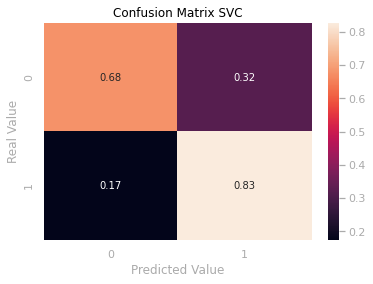

In [42]:
# Final model
svc = SVC(kernel='poly', C=1.0)
svc.fit(X_train_rus, y_train_rus)

# Prediction
X_test_svc = scaler.transform(X_test)
y_pred_svc = svc.predict(X_test_svc)

# Classification report
print(classification_report(y_test, y_pred_svc))

# Confusion matrix
fig, ax = plt.subplots()
sns.heatmap(confusion_matrix(y_test, y_pred_svc, normalize='true'), annot=True, ax=ax)
ax.set_title("Confusion Matrix SVC")
ax.set_ylabel("Real Value")
ax.set_xlabel("Predicted Value")

plt.show()

### 2. Logistic Regression

              precision    recall  f1-score   support

           0       0.95      0.61      0.74      1263
           1       0.48      0.91      0.63       498

    accuracy                           0.69      1761
   macro avg       0.71      0.76      0.68      1761
weighted avg       0.81      0.69      0.71      1761



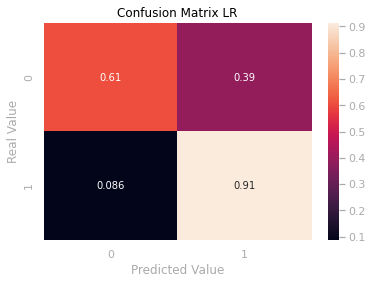

In [45]:
# Final model
lr = LogisticRegression(C=0.0001, solver='liblinear')
lr.fit(X_train_rus, y_train_rus)

# Prediction
X_test_lr = scaler.transform(X_test)
y_pred_lr = lr.predict(X_test_lr)

# Classification report
print(classification_report(y_test, y_pred_lr))

# Confusion matrix
fig, ax = plt.subplots()
sns.heatmap(confusion_matrix(y_test, y_pred_lr, normalize='true'), annot=True, ax=ax)
ax.set_title("Confusion Matrix LR")
ax.set_ylabel("Real Value")
ax.set_xlabel("Predicted Value")

plt.show()

              precision    recall  f1-score   support

           0       0.95      0.57      0.71      1263
           1       0.46      0.92      0.61       498

    accuracy                           0.67      1761
   macro avg       0.70      0.75      0.66      1761
weighted avg       0.81      0.67      0.68      1761



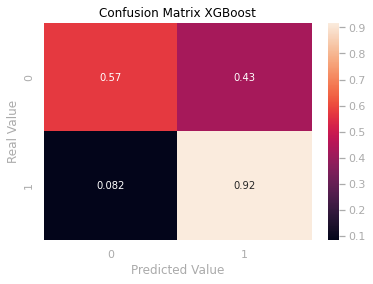

In [46]:
# Final model
xgb = XGBClassifier(learning_rate=0.0001, n_estimators=25, max_depth=1, min_child_weight=0.0001, gamma=0)
xgb.fit(X_train_rus, y_train_rus)

# Prediction
X_test_xgb = scaler.transform(X_test)
y_pred_xgb = xgb.predict(X_test_xgb)

# Classification report
print(classification_report(y_test, y_pred_xgb))

# Confusion matrix
fig, ax = plt.subplots()
sns.heatmap(confusion_matrix(y_test, y_pred_xgb, normalize='true'), annot=True, ax=ax)
ax.set_title("Confusion Matrix XGBoost")
ax.set_ylabel("Real Value")
ax.set_xlabel("Predicted Value")

plt.show()

In [54]:
X_test['Real'] = y_test
X_test['Predicted'] = y_pred_xgb

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [55]:
X_test

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,PaperlessBilling,MonthlyCharges,TotalCharges,MultipleLines_No,MultipleLines_No phone service,MultipleLines_Yes,InternetService_DSL,InternetService_Fiber optic,InternetService_No,Contract_Month-to-month,Contract_One year,Contract_Two year,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,Real,Predicted
2816,0,0,1,0,72,1,1,1,1,0,1,1,1,109.55,8165.10,0,0,1,0,1,0,0,0,1,0,0,1,0,0,0
2744,0,0,1,0,42,1,0,0,1,1,1,1,1,99.00,4135.00,1,0,0,0,1,0,0,0,1,0,1,0,0,0,0
2511,1,1,1,0,29,1,1,0,1,0,0,1,0,90.10,2656.70,1,0,0,0,1,0,0,1,0,1,0,0,0,0,0
2673,1,0,0,0,22,1,1,0,0,0,1,1,1,101.35,2317.10,0,0,1,0,1,0,1,0,0,1,0,0,0,1,1
5362,1,0,1,1,65,1,0,0,0,0,0,0,0,24.75,1715.10,0,0,1,0,0,1,0,0,1,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2887,1,0,0,0,1,1,0,0,0,0,0,0,1,45.05,45.05,1,0,0,1,0,0,1,0,0,0,0,0,1,1,1
4681,1,1,0,0,9,1,0,0,0,0,0,1,1,83.85,790.15,0,0,1,0,1,0,1,0,0,0,0,1,0,1,1
1426,1,1,1,0,71,1,1,1,1,1,0,0,1,92.00,6585.20,0,0,1,0,1,0,0,1,0,0,0,1,0,0,0
5011,0,1,1,0,43,1,1,1,0,0,1,0,1,94.50,4156.80,0,0,1,0,1,0,1,0,0,0,0,1,0,0,1
